<a href="https://colab.research.google.com/github/SelinaWu/COVID_Zipcode_NYC/blob/master/MIT_COVID19_DATATHON_TeamE001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Feature Selection and Clustering module**
## This notebook upload the preprocessed dataframe
#### 1- Performs feature selection based on RReliefF and Correlation and Lasso
#### 2- Select the intersection between the subsets chosen by each technique
#### 3- Tresholds for RRelieff and Corretion were based on the assessement of cluster tendencies we chosen


# Importing Libraries and Packages

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
import os
auth.authenticate_user()
print('Authenticated')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authenticated


# Load input data

In [2]:
import pandas as pd 
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Mounting Drive

In [3]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

Mounted at /content/drive


# List of available files

In [4]:
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/DATATHON/"

 Code			       OurHome.nyc.First.Edition.Download.xlsx
 coronavirus-data	       Presentations
 data			      'Research Paper'
 gmap.html		       Results
 mit-covid-19-datathon.ipynb  'Script - Brainstorming'
'Mobility data'		       visualization


In [0]:
# getting list of 
data_files = glob.glob("/content/drive/My Drive/data/COVID_data/*.csv")

In [0]:
# Sort inputs in reverse chronoligical order
data_files = sorted(data_files)[::-1]

# Compute the Target variable defined as IR :  average increase of daily new cases

In [0]:
# Compute average daily cases increase
daily_infection_rate = pd.DataFrame()
df_csv = pd.read_csv(data_files[0], index_col=None, header=0)

daily_infection_rate['MODZCTA'] = df_csv['MODZCTA']
daily_infection_rate['Positive_ref'] = df_csv['Positive']
daily_infection_rate['IR'] = np.nan
for filename in data_files[1:]:
    df_csv = pd.read_csv(filename, index_col=None, header=0)
    #df_csv.rename(columns={'MODZCTA':'geo_id'}, inplace=True)

    daily_infection_rate = pd.merge(daily_infection_rate, df_csv[['MODZCTA', 'Positive']], on = 'MODZCTA', how = 'inner')
    daily_infection_rate[filename.split('/')[-1]] = daily_infection_rate['Positive_ref'] - daily_infection_rate['Positive']
    daily_infection_rate['IR'] = daily_infection_rate[[filename.split('/')[-1],'IR']].mean(axis = 1)
    daily_infection_rate['Positive_ref'] = daily_infection_rate['Positive']
    
    daily_infection_rate = daily_infection_rate.drop(columns=['Positive'])
    

In [0]:
daily_infection_rate.rename(columns={'MODZCTA':'geo_id'}, inplace=True)
daily_infection_rate = daily_infection_rate.iloc[1:]
daily_infection_rate['geo_id'] = daily_infection_rate['geo_id'].astype(int)
#daily_infection_rate.info()
daily_infection_rate['geo_id'] = daily_infection_rate['geo_id'].astype(str)


# Save daily IR

In [0]:
IR_Daily_and_Avge = pd.DataFrame()
IR_Daily_and_Avge['geo_id'] = daily_infection_rate['geo_id']
IR_Daily_and_Avge['IR'] = daily_infection_rate['IR']
IR_Daily_and_Avge[daily_infection_rate.columns[3:][::-1]] = pd.DataFrame(daily_infection_rate[daily_infection_rate.columns[3:][::-1]])
IR_Daily_and_Avge.to_csv('IR_Daily_and_Avge.csv',index=False)
#!cp IR_Daily_and_Avge.csv "drive/My Drive/"
daily_infection_rate = pd.DataFrame(IR_Daily_and_Avge[['geo_id','IR']])
daily_infection_rate.head()

,geo_id,IR
1,10001,10.605568
2,10002,25.340386
3,10003,10.246684
4,10004,0.551049
5,10005,0.765631


# Load merged csv file containing all input features

In [0]:
filename = '/content/drive/My Drive/data/final_feature.csv'
input_data = pd.read_csv(filename, index_col=None, header=0)

In [120]:
input_data = pd.read_csv(filename, index_col=None, header=0)
input_data.shape

(174, 245)

In [121]:
input_data.isnull().values.any()


False

In [122]:
input_data.head()

,geo_id,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,male_21,male_22_to_24,male_25_to_29,male_30_to_34,male_35_to_39,male_40_to_44,male_45_to_49,male_50_to_54,male_55_to_59,male_65_to_66,male_67_to_69,male_70_to_74,male_75_to_79,male_80_to_84,male_85_and_over,female_under_5,female_5_to_9,female_10_to_14,female_15_to_17,female_18_to_19,female_20,female_21,female_22_to_24,female_25_to_29,female_30_to_34,female_35_to_39,female_40_to_44,female_45_to_49,...,unemployed_pop,pop_in_labor_force,not_in_labor_force,workers_16_and_over,armed_forces,civilian_labor_force,employed_agriculture_forestry_fishing_hunting_mining,employed_arts_entertainment_recreation_accommodation_food,employed_construction,employed_education_health_social,employed_finance_insurance_real_estate,employed_information,employed_manufacturing,employed_other_services_not_public_admin,employed_public_administration,employed_retail_trade,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,employed_wholesale_trade,occupation_management_arts,occupation_natural_resources_construction_maintenance,occupation_production_transportation_material,occupation_sales_office,occupation_services,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,Pop_Density,Population,land_area,new_pop_density,IR,tripcount_start,tripcount_end,station_count,average_riders
0,10464,4434.0,1893.0,2162.0,2272.0,44.9,72.0,175.0,104.0,36.0,13.0,50.0,15.0,39.0,150.0,167.0,162.0,151.0,174.0,218.0,44.0,95.0,50.0,183.0,46.0,29.0,71.0,148.0,96.0,114.0,25.0,39.0,0.0,5.0,104.0,185.0,243.0,65.0,63.0,131.0,...,153.0,2564.0,1118.0,2389.0,0.0,2564.0,0.0,221.0,118.0,646.0,225.0,128.0,36.0,171.0,228.0,192.0,254.0,44.0,148.0,1157.0,142.0,87.0,626.0,399.0,1157.0,626.0,254.0,80.0,114.0,824.0,222.0,1261.2,4532,3.593403,1233.927802,8.846466,0.0,0.0,0.0,0.0
1,10471,21896.0,8598.0,10378.0,11518.0,44.9,646.0,429.0,473.0,339.0,454.0,229.0,157.0,318.0,565.0,638.0,507.0,743.0,712.0,514.0,646.0,267.0,347.0,512.0,388.0,384.0,349.0,532.0,476.0,420.0,158.0,617.0,300.0,231.0,186.0,594.0,610.0,676.0,659.0,496.0,...,776.0,10796.0,8019.0,9802.0,0.0,10796.0,34.0,829.0,299.0,4067.0,1041.0,300.0,271.0,281.0,553.0,664.0,1338.0,254.0,89.0,5783.0,431.0,381.0,2064.0,1361.0,5783.0,2064.0,726.0,752.0,661.0,5457.0,2287.0,8459.8,21935,2.592851,8444.758641,9.111152,0.0,0.0,0.0,0.0
2,11210,67040.0,22267.0,30595.0,36445.0,35.6,2522.0,2510.0,2360.0,1627.0,887.0,481.0,251.0,1073.0,2315.0,1586.0,1937.0,2215.0,1616.0,1942.0,1816.0,619.0,961.0,1037.0,632.0,385.0,246.0,2219.0,2625.0,2615.0,1489.0,958.0,626.0,431.0,1415.0,2547.0,2398.0,2436.0,2663.0,2271.0,...,2117.0,32970.0,18279.0,30106.0,10.0,32960.0,0.0,1740.0,1282.0,12258.0,2349.0,667.0,729.0,1496.0,1577.0,2576.0,3025.0,2592.0,552.0,12443.0,1762.0,2798.0,5966.0,7874.0,12443.0,5966.0,4180.0,4063.0,4559.0,20778.0,4850.0,40852.4,67042,1.641079,40851.181289,6.719577,0.0,0.0,0.0,0.0
3,11232,27602.0,8812.0,14304.0,13298.0,33.8,765.0,919.0,657.0,425.0,262.0,148.0,99.0,622.0,1704.0,1792.0,1448.0,1066.0,1117.0,1086.0,701.0,112.0,251.0,262.0,142.0,143.0,60.0,991.0,1089.0,671.0,385.0,214.0,124.0,133.0,664.0,1547.0,1320.0,1252.0,909.0,922.0,...,941.0,14388.0,7880.0,13064.0,0.0,14388.0,20.0,2422.0,1001.0,2585.0,925.0,562.0,791.0,854.0,319.0,1258.0,1712.0,672.0,326.0,4788.0,994.0,1695.0,2524.0,3446.0,4788.0,2524.0,1699.0,1084.0,1197.0,6057.0,1075.0,22943.8,29452,1.283658,21502.606533,9.828790,16.0,575.0,1.0,4743.4
4,11428,18929.0,5558.0,9208.0,9721.0,40.8,501.0,532.0,480.0,366.0,157.0,212.0,72.0,365.0,612.0,728.0,555.0,553.0,700.0,901.0,570.0,182.0,275.0,508.0,165.0,86.0,41.0,433.0,503.0,550.0,419.0,223.0,138.0,75.0,309.0,774.0,574.0,582.0,616.0,759.0,...,562.0,9784.0,5917.0,9015.0,0.0,9784.0,47.0,702.0,557.0,2554.0,852.0,248.0,450.0,496.0,353.0,1016.0,778.0,1023.0,146.0,2546.0,1035.0,1288.0,2341.0,2012.0,2546.0,234

# Feature selection

In [0]:
# Define input and output
y = input_data['IR'] #target variable

In [0]:
input_data.drop(['IR','Pop_Density','Population','land_area'], axis=1, inplace=True)

In [125]:
input_data.head()

,geo_id,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,male_21,male_22_to_24,male_25_to_29,male_30_to_34,male_35_to_39,male_40_to_44,male_45_to_49,male_50_to_54,male_55_to_59,male_65_to_66,male_67_to_69,male_70_to_74,male_75_to_79,male_80_to_84,male_85_and_over,female_under_5,female_5_to_9,female_10_to_14,female_15_to_17,female_18_to_19,female_20,female_21,female_22_to_24,female_25_to_29,female_30_to_34,female_35_to_39,female_40_to_44,female_45_to_49,...,male_45_64_high_school,male_45_64_some_college,male_45_to_64,employed_pop,unemployed_pop,pop_in_labor_force,not_in_labor_force,workers_16_and_over,armed_forces,civilian_labor_force,employed_agriculture_forestry_fishing_hunting_mining,employed_arts_entertainment_recreation_accommodation_food,employed_construction,employed_education_health_social,employed_finance_insurance_real_estate,employed_information,employed_manufacturing,employed_other_services_not_public_admin,employed_public_administration,employed_retail_trade,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,employed_wholesale_trade,occupation_management_arts,occupation_natural_resources_construction_maintenance,occupation_production_transportation_material,occupation_sales_office,occupation_services,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,new_pop_density,tripcount_start,tripcount_end,station_count,average_riders
0,10464,4434.0,1893.0,2162.0,2272.0,44.9,72.0,175.0,104.0,36.0,13.0,50.0,15.0,39.0,150.0,167.0,162.0,151.0,174.0,218.0,44.0,95.0,50.0,183.0,46.0,29.0,71.0,148.0,96.0,114.0,25.0,39.0,0.0,5.0,104.0,185.0,243.0,65.0,63.0,131.0,...,144.0,101.0,554.0,2411.0,153.0,2564.0,1118.0,2389.0,0.0,2564.0,0.0,221.0,118.0,646.0,225.0,128.0,36.0,171.0,228.0,192.0,254.0,44.0,148.0,1157.0,142.0,87.0,626.0,399.0,1157.0,626.0,254.0,80.0,114.0,824.0,222.0,1233.927802,0.0,0.0,0.0,0.0
1,10471,21896.0,8598.0,10378.0,11518.0,44.9,646.0,429.0,473.0,339.0,454.0,229.0,157.0,318.0,565.0,638.0,507.0,743.0,712.0,514.0,646.0,267.0,347.0,512.0,388.0,384.0,349.0,532.0,476.0,420.0,158.0,617.0,300.0,231.0,186.0,594.0,610.0,676.0,659.0,496.0,...,537.0,436.0,2633.0,10020.0,776.0,10796.0,8019.0,9802.0,0.0,10796.0,34.0,829.0,299.0,4067.0,1041.0,300.0,271.0,281.0,553.0,664.0,1338.0,254.0,89.0,5783.0,431.0,381.0,2064.0,1361.0,5783.0,2064.0,726.0,752.0,661.0,5457.0,2287.0,8444.758641,0.0,0.0,0.0,0.0
2,11210,67040.0,22267.0,30595.0,36445.0,35.6,2522.0,2510.0,2360.0,1627.0,887.0,481.0,251.0,1073.0,2315.0,1586.0,1937.0,2215.0,1616.0,1942.0,1816.0,619.0,961.0,1037.0,632.0,385.0,246.0,2219.0,2625.0,2615.0,1489.0,958.0,626.0,431.0,1415.0,2547.0,2398.0,2436.0,2663.0,2271.0,...,1959.0,1424.0,6951.0,30843.0,2117.0,32970.0,18279.0,30106.0,10.0,32960.0,0.0,1740.0,1282.0,12258.0,2349.0,667.0,729.0,1496.0,1577.0,2576.0,3025.0,2592.0,552.0,12443.0,1762.0,2798.0,5966.0,7874.0,12443.0,5966.0,4180.0,4063.0,4559.0,20778.0,4850.0,40851.181289,0.0,0.0,0.0,0.0
3,11232,27602.0,8812.0,14304.0,13298.0,33.8,765.0,919.0,657.0,425.0,262.0,148.0,99.0,622.0,1704.0,1792.0,1448.0,1066.0,1117.0,1086.0,701.0,112.0,251.0,262.0,142.0,143.0,60.0,991.0,1089.0,671.0,385.0,214.0,124.0,133.0,664.0,1547.0,1320.0,1252.0,909.0,922.0,...,671.0,408.0,3427.0,13447.0,941.0,14388.0,7880.0,13064.0,0.0,14388.0,20.0,2422.0,1001.0,2585.0,925.0,562.0,791.0,854.0,319.0,1258.0,1712.0,672.0,326.0,4788.0,994.0,1695.0,2524.0,3446.0,4788.0,2524.0,1699.0,1084.0,1197.0,6057.0,1075.0,21502.606533,16.0,575.0,1.0,4743.4
4,11428,18929.0,5558.0,9208.0,9721.0,40.8,501.0,532.0,480.0,366.0,157.0,212.0,72.0,365.0,612.0,728.0,555.0,553.0,700.0,901.0,570.0,182.0,275.0,508.0,165.0,86.0,41.0,433.0,503.0,550.0,419.0,223.0,138.0,75.0,309.0,774.0,574.0,582.0,616.0,759.0,...,1126.0,550.0,2818.0,9222.0,562.0,9784.0,5917.0,9015.0,0.0,9784.0,47.0,702.0,557.0,2554.0,852.0,248.0,450.0,496.0,353.0,1016.0,778.0,1023.0,146

In [0]:
X = input_data.iloc[:,1:] # Raw input features
Features = input_data.columns[1:]
zips = input_data['geo_id'] 

In [127]:
X.head()

,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,male_21,male_22_to_24,male_25_to_29,male_30_to_34,male_35_to_39,male_40_to_44,male_45_to_49,male_50_to_54,male_55_to_59,male_65_to_66,male_67_to_69,male_70_to_74,male_75_to_79,male_80_to_84,male_85_and_over,female_under_5,female_5_to_9,female_10_to_14,female_15_to_17,female_18_to_19,female_20,female_21,female_22_to_24,female_25_to_29,female_30_to_34,female_35_to_39,female_40_to_44,female_45_to_49,female_50_to_54,...,male_45_64_high_school,male_45_64_some_college,male_45_to_64,employed_pop,unemployed_pop,pop_in_labor_force,not_in_labor_force,workers_16_and_over,armed_forces,civilian_labor_force,employed_agriculture_forestry_fishing_hunting_mining,employed_arts_entertainment_recreation_accommodation_food,employed_construction,employed_education_health_social,employed_finance_insurance_real_estate,employed_information,employed_manufacturing,employed_other_services_not_public_admin,employed_public_administration,employed_retail_trade,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,employed_wholesale_trade,occupation_management_arts,occupation_natural_resources_construction_maintenance,occupation_production_transportation_material,occupation_sales_office,occupation_services,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,new_pop_density,tripcount_start,tripcount_end,station_count,average_riders
0,4434.0,1893.0,2162.0,2272.0,44.9,72.0,175.0,104.0,36.0,13.0,50.0,15.0,39.0,150.0,167.0,162.0,151.0,174.0,218.0,44.0,95.0,50.0,183.0,46.0,29.0,71.0,148.0,96.0,114.0,25.0,39.0,0.0,5.0,104.0,185.0,243.0,65.0,63.0,131.0,192.0,...,144.0,101.0,554.0,2411.0,153.0,2564.0,1118.0,2389.0,0.0,2564.0,0.0,221.0,118.0,646.0,225.0,128.0,36.0,171.0,228.0,192.0,254.0,44.0,148.0,1157.0,142.0,87.0,626.0,399.0,1157.0,626.0,254.0,80.0,114.0,824.0,222.0,1233.927802,0.0,0.0,0.0,0.0
1,21896.0,8598.0,10378.0,11518.0,44.9,646.0,429.0,473.0,339.0,454.0,229.0,157.0,318.0,565.0,638.0,507.0,743.0,712.0,514.0,646.0,267.0,347.0,512.0,388.0,384.0,349.0,532.0,476.0,420.0,158.0,617.0,300.0,231.0,186.0,594.0,610.0,676.0,659.0,496.0,652.0,...,537.0,436.0,2633.0,10020.0,776.0,10796.0,8019.0,9802.0,0.0,10796.0,34.0,829.0,299.0,4067.0,1041.0,300.0,271.0,281.0,553.0,664.0,1338.0,254.0,89.0,5783.0,431.0,381.0,2064.0,1361.0,5783.0,2064.0,726.0,752.0,661.0,5457.0,2287.0,8444.758641,0.0,0.0,0.0,0.0
2,67040.0,22267.0,30595.0,36445.0,35.6,2522.0,2510.0,2360.0,1627.0,887.0,481.0,251.0,1073.0,2315.0,1586.0,1937.0,2215.0,1616.0,1942.0,1816.0,619.0,961.0,1037.0,632.0,385.0,246.0,2219.0,2625.0,2615.0,1489.0,958.0,626.0,431.0,1415.0,2547.0,2398.0,2436.0,2663.0,2271.0,1854.0,...,1959.0,1424.0,6951.0,30843.0,2117.0,32970.0,18279.0,30106.0,10.0,32960.0,0.0,1740.0,1282.0,12258.0,2349.0,667.0,729.0,1496.0,1577.0,2576.0,3025.0,2592.0,552.0,12443.0,1762.0,2798.0,5966.0,7874.0,12443.0,5966.0,4180.0,4063.0,4559.0,20778.0,4850.0,40851.181289,0.0,0.0,0.0,0.0
3,27602.0,8812.0,14304.0,13298.0,33.8,765.0,919.0,657.0,425.0,262.0,148.0,99.0,622.0,1704.0,1792.0,1448.0,1066.0,1117.0,1086.0,701.0,112.0,251.0,262.0,142.0,143.0,60.0,991.0,1089.0,671.0,385.0,214.0,124.0,133.0,664.0,1547.0,1320.0,1252.0,909.0,922.0,751.0,...,671.0,408.0,3427.0,13447.0,941.0,14388.0,7880.0,13064.0,0.0,14388.0,20.0,2422.0,1001.0,2585.0,925.0,562.0,791.0,854.0,319.0,1258.0,1712.0,672.0,326.0,4788.0,994.0,1695.0,2524.0,3446.0,4788.0,2524.0,1699.0,1084.0,1197.0,6057.0,1075.0,21502.606533,16.0,575.0,1.0,4743.4
4,18929.0,5558.0,9208.0,9721.0,40.8,501.0,532.0,480.0,366.0,157.0,212.0,72.0,365.0,612.0,728.0,555.0,553.0,700.0,901.0,570.0,182.0,275.0,508.0,165.0,86.0,41.0,433.0,503.0,550.0,419.0,223.0,138.0,75.0,309.0,774.0,574.0,582.0,616.0,759.0,778.0,...,1126.0,550.0,2818.0,9222.0,562.0,9784.0,5917.0,9015.0,0.0,9784.0,47.0,702.0,557.0,2554.0,852.0,248.0,450.0,496.0,353.0,1016.0,778.0,

**Run Feature Selection algorithms**

In [128]:
# X np.array input features
# y np.array target variable
# F List of feature names (list of strings)

from sklearn import linear_model
!pip install sklearn-relief==1.0.0b2
import sklearn_relief as relief

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

def select_features(X,y,normalize): #normalize is 0 or 1 

  if normalize == 1:
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(X) 
    X.loc[:,:] = scaled_values
  
  if normalize == 2:
     
    scaled_values = preprocessing.scale(X) 
    X.loc[:,:] = scaled_values


  corr_FS = dict()
  relief_FS = dict()
  lasso_FS = dict()

  ## Correaltion
  correlation = X.corrwith(y, axis = 0).abs()
  corr_FS['ranked_W'] = sorted(list(correlation))[::-1]
  corr_FS['ranked_idx'] = np.argsort(np.array(list(correlation)))[::-1]

  ## rReliefF
  r = relief.RReliefF(n_features=list(X.shape)[1])# Choose the best 3 features
  my_transformed_matrix = r.fit_transform(np.asarray(X), np.asarray(y))
  relief_FS['ranked_idx'] = np.argsort(r.w_)[::-1]
  relief_FS['ranked_W']  = r.w_[np.argsort(r.w_)[::-1]]

  ## Lasso
  clf = linear_model.Lasso(alpha=0.1)
  clf.fit(X, y)
  lasso_FS['ranked_idx'] = np.argsort(np.abs(clf.coef_))[::-1]
  lasso_FS['ranked_W']  = clf.coef_[np.argsort(clf.coef_)[::-1]]

  return corr_FS, relief_FS, lasso_FS


In [129]:
# Run feature selection 
corr_FS, relief_FS, lasso_FS = select_features(X,y,0)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.91488515362143, tolerance: 0.1075186250546655
  positive)


# Select to subset of features 

In [160]:
##Selected Corr Features
mask_coor = np.array(corr_FS['ranked_W']) >= 0.3#np.array(corr_FS['ranked_W']).mean()#0.5 # 0.6 threshold for corr, -10 for relief ## Thresholds are chosen based on trial and error
select_idxC = corr_FS['ranked_idx'][mask_coor]
print(select_idxC)
features_Corr = pd.DataFrame()
features_Corr['Corr - selected features'] = [Features[i] for i in  select_idxC]
print(features_Corr['Corr - selected features'])
features_Corr.to_csv('FS_Corr_0.csv',index=False)
!cp FS_Corr_0.csv "drive/My Drive/DATATHON/Results - bis"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


[ 53  59  52  61  60  57  58  80 104 131 103 101  79 102  96 237 236 214
 132 167 193 130 154 142 197 164 146 161 188 194 144 215 177 107 221 127
 201 220 190 192 225 227 200 183 187  69  65 199 181 235]
0                                       pop_15_and_over
1                                         pop_separated
2                                      pop_5_years_over
3                                          pop_divorced
4                                           pop_widowed
5                                     pop_never_married
6                                       pop_now_married
7                                     income_per_capita
8     owner_occupied_housing_units_upper_value_quartile
9                                           median_rent
10            owner_occupied_housing_units_median_value
11    renter_occupied_housing_units_paying_cash_medi...
12                                        median_income
13    owner_occupied_housing_units_lower_value_quartile
14          

In [153]:
##Selected Corr Features
mask_coor = np.array(lasso_FS['ranked_W']) >= 0.8* np.array(lasso_FS['ranked_W']).mean() #!= 0#np.array(corr_FS['ranked_W']).mean()#0.5 # 0.6 threshold for corr, -10 for relief ## Thresholds are chosen based on trial and error
select_idxL = lasso_FS['ranked_idx'][mask_coor]
print(select_idxL)
features_Corr = pd.DataFrame()
features_Corr['Lasso - selected features'] = [Features[i] for i in  select_idxL]
print(features_Corr['Lasso - selected features'])
features_Corr.to_csv('FS_lasso_0.csv',index=False)
!cp FS_lasso_0.csv "drive/My Drive/DATATHON/Results - bis"

[132 118 208  25  24  22 127  76 210  46 173  31 108  83  43 156  66 128
 197  11   8 137  73 168 131  95  36  94  89 214  72  48 222  77  17  12
   9  32  33 201  45 142  87 216  38  29  23 215 154  92  10  91 219 236
 199 218]
0                          percent_income_spent_on_rent
1                                          mobile_homes
2                                          armed_forces
3                                      male_85_and_over
4                                         male_80_to_84
5                                         male_70_to_74
6                                  male_male_households
7                                   hispanic_male_55_64
8     employed_agriculture_forestry_fishing_hunting_...
9                                       female_75_to_79
10                                           three_cars
11                                            female_20
12                        vacant_housing_units_for_rent
13                                   income

In [164]:
##Selected RReliefF Features
mask_coor = np.array(relief_FS['ranked_W']) >= 0.8*np.array(relief_FS['ranked_W']).mean()  # 0.6 threshold for corr, -10 for relief ## Thresholds are chosen based on trial and error
select_idxR = relief_FS['ranked_idx'][mask_coor]
print(select_idxR)
features_Relief = pd.DataFrame()
features_Relief['Relief - selected features'] = [Features[i] for i in  select_idxR]
print(features_Relief['Relief - selected features'])
features_Relief.to_csv('FS_Relief_0.csv',index=False)
!cp FS_Relief_0.csv "drive/My Drive/DATATHON/Results - bis"

[239  79  80 103  49  69  65  63  70  64 143  98 223 228 192 194   3  62
 206 185  96 190 107 123 188 100 130 145 182  81 112 146 126 134 191 184
  68 154  67  78  74 172  95 232 183  30  75  76 217  77 213  72 161 144
 204   9 214 227 234  93 111]
0                                average_riders
1                                 median_income
2                             income_per_capita
3     owner_occupied_housing_units_median_value
4                                     white_pop
                        ...                    
56       employed_finance_insurance_real_estate
57                          occupation_services
58                         in_undergrad_college
59                         income_100000_124999
60                   dwellings_1_units_attached
Name: Relief - selected features, Length: 61, dtype: object


# **Merge three FS techniques**

In [165]:
final_feature_set_union =  list(set(select_idxL) | set(select_idxR)) #set(select_idxR) | 
np.array(final_feature_set_union) #one_parent_families_with_young_childrenintersection
## SAVE FEATURES IN CSV FILE
features = pd.DataFrame()
features['Union- FS'] = [Features[i] for i in  final_feature_set_union]
print(features['Union- FS'] )
features.to_csv('FS_UNION_0.csv',index=False)
!cp FS_UNION_0.csv "drive/My Drive/DATATHON/Results - bis"

0                                 female_pop
1                              male_15_to_17
2                              male_18_to_19
3                                    male_20
4                                    male_21
                       ...                  
105    management_business_sci_arts_employed
106                        in_grades_9_to_12
107                     in_undergrad_college
108                          tripcount_start
109                           average_riders
Name: Union- FS, Length: 110, dtype: object


In [168]:
final_feature_set_inter =  list(set(select_idxL) & set(select_idxR)) #set(select_idxR) | 
np.array(final_feature_set_inter) #one_parent_families_with_young_childrenintersection
## SAVE FEATURES IN CSV FILE
features = pd.DataFrame()
features['Inter- FS'] = [Features[i] for i in  final_feature_set_inter]
print(features['Inter- FS'] )
features.to_csv('FS_INTER_0.csv',index=False)
!cp FS_INTER_0.csv "drive/My Drive/DATATHON/Results - bis"

0                           asian_male_55_64
1                              male_18_to_19
2                        hispanic_male_55_64
3                           white_male_45_54
4     employed_finance_insurance_real_estate
5    one_parent_families_with_young_children
6                       income_150000_199999
Name: Inter- FS, dtype: object


# Clustering

In [0]:
#corr_select_idx = select_idx
num_clusters = 5
reduced_data = X.iloc[:,final_feature_set_union]


##kmeans_2 = KMeans(n_clusters=num_clusters).fit(reduced_data)
#ultimate = kmeans_2
census_data_embedded_2 = TSNE(n_components=2).fit_transform(reduced_data)

In [175]:

reduced_data.shape
#kmeans_2_relief = kmeans_2

(174, 110)

# **Assign cluster IDs based on the ranking of the average IR among member zips** (For interpretability reasons)

In [0]:

##
covid_data = pd.DataFrame()
covid_data['IR'] = y
cov2 = covid_data.groupby(kmeans_2.labels_).mean()
cov2.shape

sorted_avIR = np.argsort(cov2['IR'])




##

cluster_ids = kmeans_2.labels_[:]

cluster_ids_ = np.zeros(len(cluster_ids)).astype(int)

for j in range(num_clusters):
  mask = cluster_ids == sorted_avIR[j].astype(int)
  cluster_ids_[mask] = j
  


# **Scatter plot of clusters in t-SNE 2D embedded feature space**

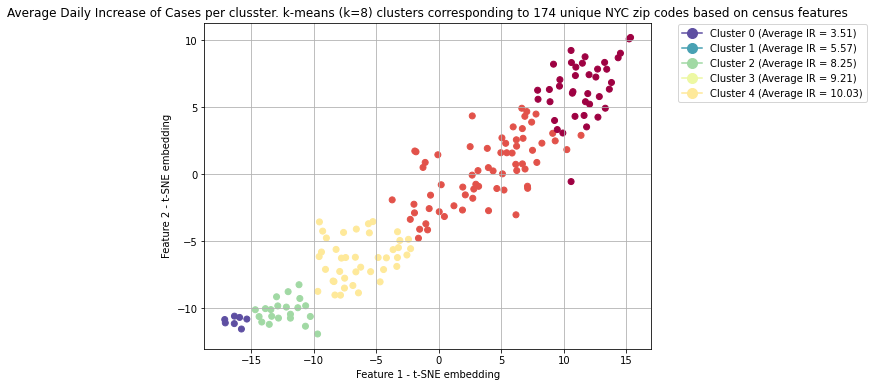

In [183]:
## 
# Create custom legend
from matplotlib.lines import Line2D
from matplotlib import cm
cmaps = cm.get_cmap('Spectral_r', 8)

#num_clusters = 8
legend_elements = []
measure = np.array(cov2['IR'][sorted_avIR])

for i in range(num_clusters):
 
  legend_elements.append(Line2D([0], [0], marker='o', color=cmaps(i), label='Cluster '+str(i) + ' (Average IR = '+str('{:.2f}'.format(measure[i]))+')', markerfacecolor=cmaps(i) , markersize=10))


# Create the figure
# Visualize it:
plt.figure(figsize=(8, 6))
#sns.swarmplot(census_data_embedded_2[:,0], census_data_embedded_2[:,1], c=kmeans_2.labels_.astype(float))
plt.scatter(census_data_embedded_2[:,0], census_data_embedded_2[:,1], c=cluster_ids_.astype(float), cmap = cmaps)
plt.grid()
plt.legend(handles=legend_elements, bbox_to_anchor=[1.05, 1.01])
plt.xlabel('Feature 1 - t-SNE embedding')
plt.ylabel('Feature 2 - t-SNE embedding')
plt.title('Average Daily Increase of Cases per clusster. k-means (k=8) clusters corresponding to 174 unique NYC zip codes based on census features')
plt.show()




In [118]:
reduced_data.head()

,children_in_single_female_hh,median_rent,percent_income_spent_on_rent,rent_under_10_percent,million_dollar_housing_units,different_house_year_ago_different_city,one_parent_families_with_young_children,commute_25_29_mins,commute_60_more_mins,walked_to_work,commuters_by_bus,pop_5_years_over,pop_15_and_over,commuters_drove_alone,associates_degree,pop_never_married,pop_now_married,pop_separated,one_year_more_college,pop_widowed,pop_divorced,high_school_including_ged,bachelors_degree_or_higher_25_64,graduate_professional_degree,some_college_and_associates_degree,masters_degree,hispanic_pop,male_45_64_graduate_degree,hispanic_any_race,male_45_64_grade_9_12,male_45_64_high_school,male_45_64_some_college,median_income,income_per_capita,employed_finance_insurance_real_estate,employed_information,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,income_200000_or_more,occupation_production_transportation_material,occupation_services,renter_occupied_housing_units_paying_cash_median_gross_rent,owner_occupied_housing_units_lower_value_quartile,owner_occupied_housing_units_median_value,owner_occupied_housing_units_upper_value_quartile,vacant_housing_units,tripcount_start,tripcount_end,new_pop_density,male_male_households
0,0.016097,0.328050,0.596349,0.014409,0.014155,0.009194,0.030152,0.005333,0.026580,0.004662,0.012405,0.0,0.0,0.057484,0.058467,0.0,0.0,0.0,0.024257,0.0,0.0,0.028647,0.010527,0.018199,0.034630,0.021613,0.011858,0.000000,0.011858,0.014171,0.025428,0.044969,0.320016,0.271936,0.004288,0.025948,0.011118,0.007611,0.018059,0.009006,0.016867,0.349440,0.276229,0.255628,0.33565,0.024343,0.000000,0.000000,0.000000,0.050964
1,0.038152,0.435108,0.572008,0.115274,0.055471,0.121672,0.043903,0.129947,0.154970,0.036833,0.126273,0.0,0.0,0.155263,0.120267,0.0,0.0,0.0,0.159604,0.0,0.0,0.088750,0.151916,0.180832,0.158902,0.189636,0.057707,0.188498,0.057707,0.030257,0.097844,0.194123,0.286080,0.267747,0.096367,0.060815,0.101062,0.043937,0.105102,0.042522,0.063361,0.456099,0.130175,0.161174,0.33465,0.128706,0.000000,0.000000,0.047788,0.035813
2,0.320996,0.373804,0.632860,0.076209,0.353481,0.044537,0.343936,0.305361,0.477515,0.108332,0.400908,0.0,0.0,0.369573,0.449258,0.0,0.0,0.0,0.635941,0.0,0.0,0.399342,0.332087,0.232258,0.576383,0.308118,0.054321,0.224625,0.054321,0.212945,0.359867,0.634016,0.198308,0.124604,0.243963,0.135212,0.241039,0.448365,0.147991,0.318057,0.378135,0.398645,0.285480,0.301916,0.43505,0.231128,0.000000,0.000000,0.262556,0.024793
3,0.101844,0.412978,0.691684,0.084854,0.211171,0.117254,0.115142,0.087567,0.163013,0.079378,0.067474,0.0,0.0,0.035141,0.118449,0.0,0.0,0.0,0.148020,0.0,0.0,0.158860,0.131112,0.080104,0.140547,0.110930,0.163552,0.093881,0.163552,0.225584,0.122535,0.181656,0.157367,0.100415,0.083277,0.113927,0.132094,0.116243,0.046682,0.192316,0.164129,0.439599,0.259038,0.343743,0.52535,0.051664,0.004278,0.008593,0.134327,0.000000
4,0.045060,0.402811,0.916836,0.006084,0.007269,0.011940,0.040590,0.067359,0.151488,0.009454,0.154917,0.0,0.0,0.182210,0.199485,0.0,0.0,0.0,0.161089,0.0,0.0,0.173046,0.034682,0.024464,0.187292,0.033982,0.055253,0.005161,0.055253,0.108771,0.206376,0.244880,0.232868,0.098462,0.075039,0.050274,0.054597,0.176959,0.023205,0.145919,0.094824,0.438126,0.271373,0.225411,0.29640,0.043895,0.000000,0.000000,0.142490,0.000000


In [67]:
y.mean()

8.500984959301825

In [0]:


##
Zip_clusterIDs_IR = pd.DataFrame()
Zip_clusterIDs_IR = pd.DataFrame(covid_data[['IR']])
Zip_clusterIDs_IR['geo_id'] = zips
Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
Zip_clusterIDs_IR.to_csv('final_ZIP_avIR_clusterIDs.csv',index=False)
!cp final_ZIP_avIR_clusterIDs.csv "drive/My Drive/DATATHON/Results - bis/Clusters"

## **Underlying factors embedding:**Aggregate features by categories

In [0]:
## DEfine feature withing categories indices: (manually done from the saved excel sheet of the selected features)
Familial = reduced_data.iloc[:,np.array([2,4,5,6,8,15,30,45,52,54,70,74])-2]
Age_Gender = reduced_data.iloc[:,np.array([3,7,9,16,17,20,24,26,27,37,38,42,47,48,50,51,53,55,56,57,62,63,65,66,68,69,73,40,33,34,44,87])-2]
Education_level = reduced_data.iloc[:,np.array([10,12,13,18,19,21,22,25,29,61,95,96,34,89])-2]
occupation = reduced_data.iloc[:,np.array([11,14,28,31,41,67,71,72,104,108,109,110,49])-2]
Mobility = reduced_data.iloc[:,np.array([114,112,111,103,91,90,85,79,78,77,76,75,64,32,23,99])-2]
Income = reduced_data.iloc[:,np.array([36,39,43,46,58,59,60,80,81,88,97,105])-2]
Race = reduced_data.iloc[:,np.array([82,83,84,86,102])-2]

In [0]:
factors = [Familial,Age_Gender,Education_level,occupation,Mobility,Income,Race]
factors_IDs = ['Familial','Age_Gender','Education_level','occupation','Mobility','Income','Race']

In [0]:
##embed features
def embed_features(factors,factors_IDs,covid_data,cluster_ids_,zips):
  
  embd_X =  dict()
  for j in range(len(factors)):

    cat1 = TSNE(n_components=1).fit_transform(factors[j])
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(cat1) 
    embd_X[factors_IDs[j]] = list(scaled_values)
    print(j)
    Zip_clusterIDs_IR = pd.DataFrame()
    Zip_clusterIDs_IR = pd.DataFrame(scaled_values)
    Zip_clusterIDs_IR['geo_id'] = zips
    Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
    Zip_clusterIDs_IR.to_csv(factors_IDs[j]+'.csv',index=False)

    #!cp vars()[factors_IDs[j]+'.csv'] "drive/My Drive/DATATHON/Results/Clusters"

    return embd_X

embd_X = embed_features(factors,factors_IDs,covid_data,cluster_ids_,zips)


0


In [0]:
embd_X =  dict()
for j in range(len(factors)):

  cat1 = TSNE(n_components=1).fit_transform(factors[j])
  scaler = MinMaxScaler() 
  scaled_values = scaler.fit_transform(cat1) 
  embd_X[factors_IDs[j]] = scaled_values
  print(j)
  Zip_clusterIDs_IR = pd.DataFrame()
  Zip_clusterIDs_IR = pd.DataFrame(scaled_values)
  Zip_clusterIDs_IR['geo_id'] = zips
  Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
  Zip_clusterIDs_IR.to_csv(factors_IDs[j]+'.csv',index=False)

0
1
2
3
4
5
6


In [0]:
#"drive/My Drive/DATATHON/Results/Clusters"
factors_IDs

['Familial',
 'Age_Gender',
 'Education_level',
 'occupation',
 'Mobility',
 'Income',
 'Race']

In [0]:
## Save 1D embedded factors for geo plots
!cp Familial.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Age_Gender.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Education_level.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp occupation.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Mobility.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Income.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Race.csv "drive/My Drive/DATATHON/Results/Clusters"

# **Boxplot of the embedded factors grouped by clusters**

In [0]:
filename = '/content/drive/My Drive/DATATHON/Results/Clusters/embedded_features.csv'
embedded_Cats = pd.read_csv(filename, index_col=None, header=0)
embedded_Cats.head()
ref = embedded_Cats['ClusterID']

In [0]:
embedded_Cats.drop(columns=['ClusterID'])

,Familial,Age_Gender,Education_level,occupation,Mobility,Income,Race
0,0.084536,0.065665,0.876152,0.862447,0.000001,0.000000,0.116901
1,0.181849,0.179008,0.804295,0.718391,0.144257,0.112878,0.228025
2,0.805610,0.697310,0.232879,0.243008,0.824774,0.777811,0.419871
3,0.316300,0.265273,0.754214,0.725829,0.214609,0.201798,0.601757
4,0.185985,0.149419,0.786290,0.781787,0.139859,0.112610,0.584196
...,...,...,...,...,...,...,...
169,0.566066,0.633050,0.348378,0.905404,0.772290,0.691876,0.418860
170,0.841337,0.838072,0.180321,0.166593,0.940248,0.911484,0.907581
171,0.880936,0.873148,0.111613,0.106875,0.943761,0.951407,0.308235
172,0.731832,0.726221,0.339847,0.239235,0.891427,0.787861,0.784706


[[None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None]]

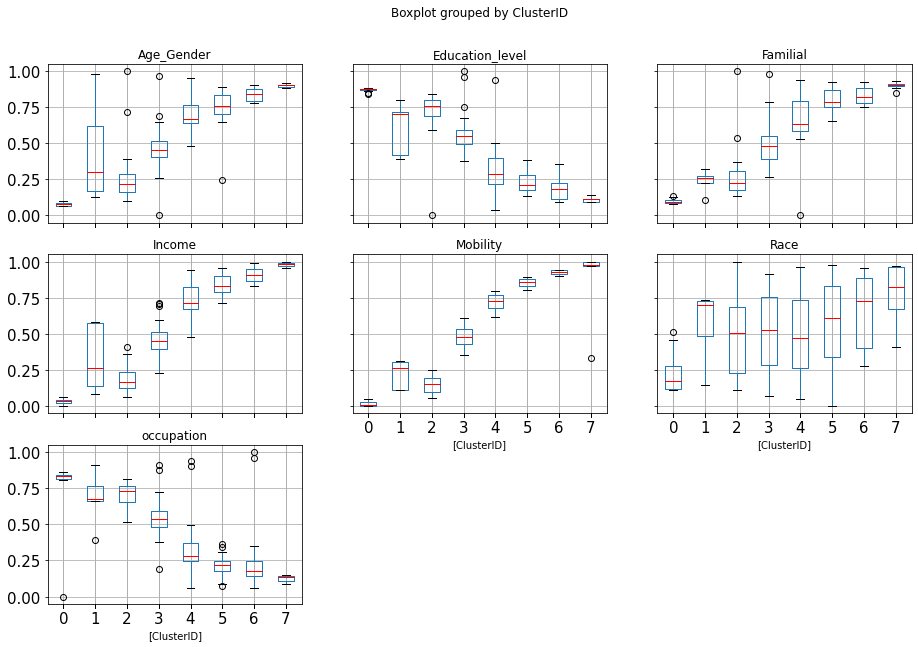

In [0]:
#plt.figure(figsize=(15,10))
bp = embedded_Cats.boxplot(by='ClusterID',figsize=(15,10),return_type='dict', fontsize=15)
#[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
#fig = np.asarray(bp).reshape(-1)[0].get_figure()
[[item.set_color('r') for item in bp[key]['medians']] for key in bp.keys()]

[[None, None, None, None, None, None, None, None]]

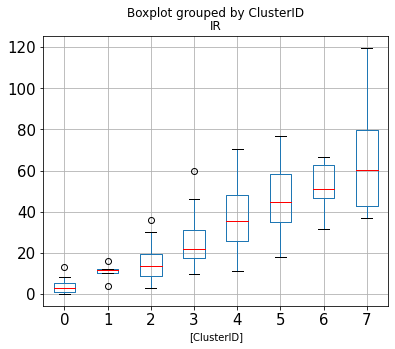

In [0]:

filename = '/content/drive/My Drive/DATATHON/Results/Clusters/CovidIR_Clusters.csv'
embedded_Cats = pd.read_csv(filename, index_col=None, header=0)
#embedded_Cats = embedded_features.csv
#embedded_Cats.reset_index()
#embedded_Cats['Education_level']
embedded_Cats.head()
ref = embedded_Cats['ClusterID']


#plt.figure(figsize=(3,4))
bp = embedded_Cats.boxplot(by='ClusterID',figsize=(6,5),return_type='dict', fontsize=15)
#[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
#fig = np.asarray(bp).reshape(-1)[0].get_figure()
[[item.set_color('r') for item in bp[key]['medians']] for key in bp.keys()]

In [0]:
embd_X.shape

(1, 174, 1)

# Elbow to find clusters

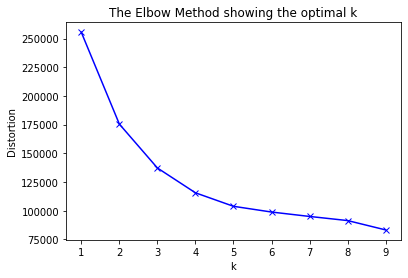

In [178]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(reduced_data)
    kmeanModel.fit(reduced_data)
    distortions.append(sum(np.min(cdist(reduced_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()